# Computer Vision Programming Assignment 2
본 자료는 광주과학기술원 AI대학원 `EC5303 Computer Vision`의 `Programming Assignment 2 - Structure from Motion`에 대한 코드 및 정답을 포함합니다.

이 자료는 과제 제출을 위한 코드 정리 및 결과 보고를 위주로 작성된 결과 보고서입니다.

Python code에 대한 상세한 사용방법은 `README.md`를 참조해주시기 바랍니다.

보고서는 다음과 같은 순서로 서술되어 있습니다.

1. 패키지 및 편의 함수
2. 이미지 불러오기
3. Feature Extraction and Matching
4. Estimate Essential Matrix
5. Triangulation
6. Visualization by MeshLab

## Import Packages

전체 연산에 필요한 패키지를 임포트합니다. `이미지 처리`, `행렬 연산`, `시각화`를 위한 패키지입니다.

패키지 중 `oct2py`는 운영체제에 설치된 `octave`를 기반으로 작동합니다. `octave`설치에 대한 자세한 설명은 `README.md`를 참조해주세요.

In [41]:
import cv2
import numpy as np
from oct2py import octave
# Set octave path
octave.addpath(os.path.abspath('Givenfunctions/'))
from matplotlib import pyplot as plt
from matplotlib import cm

import os
import warnings
warnings.filterwarnings(action='ignore')

## Load Images

Stereo images를 사용하기에 2 장의 이미지를 불러옵니다. 불러온 각 이미지는 `Feature matching`을 위하여 `Gray scale`로 변환합니다. 불러온 이미지는 아래와 같습니다.

In [5]:
# Load images
filename = [
    'data/dataset_two-view/sfm01.jpg',
    'data/dataset_two-view/sfm02.jpg'
]
img = [cv2.imread(f) for f in filename]
gray = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in img]

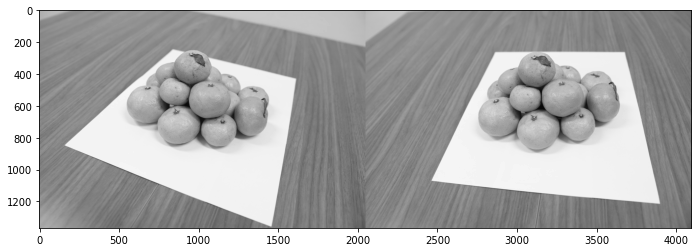

In [32]:
grays = np.concatenate([gray[0], gray[1]], axis=1)
plt.figure(figsize=(12,4))
plt.imshow(grays, cmap=cm.gray)
plt.show()

---

## Feature Extraction

불러온 이미지로부터 `Feature descriptors`를 검출합니다. `opencv`의 `SIFT`를 사용하여 이미지로부터 `Feature`를 추출하고, `opencv`의 `detectAndCompute` 함수를 사용하여 `Keypoints`와 `Descriptors`를 검출합니다.

In [9]:
def image_to_sift(img):
    # create SIFT
    sift = cv2.SIFT_create()
    # Detect keypoints and descriptors
    kp = []
    desc = []
    for i in range(len(img)):
        tmp_kp, tmp_desc = sift.detectAndCompute(img[i], None)
        kp.append(tmp_kp)
        desc.append(tmp_desc)

    return kp, desc

In [10]:
kp, desc = image_to_sift(img)

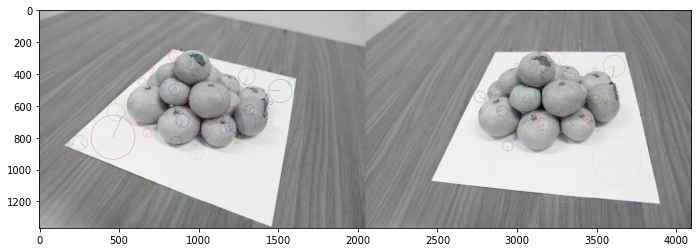

In [20]:
img_kp = [
    cv2.drawKeypoints(gray[i], kp[i], img[i],
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) for i in range(len(img))
]
img_kp = np.concatenate([img_kp[0], img_kp[1]], axis=1)
plt.figure(figsize=(12,4))
plt.imshow(img_kp)
plt.show()

## Feature Matching

앞서 검출한 `Descriptors`를 사용하여 `Feature matching`을 진행합니다. `opencv`의 `FlannBasedMatcher`와 `knnMatch`를 사용합니다. 각 클래스와 함수에 대한 파라미터는 코드를 참조해 주십시오.

먼저 `match points`를 계산합니다.

In [22]:
FLANN_INDEX_KDTREE = 0
index_params = {'algorithm':FLANN_INDEX_KDTREE, 'trees':5}
search_params = {'checks': 50}

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc[0], desc[1], k=2, compactResult=True)

계산된 `match points`를 시각화 합니다.

In [30]:
matchesMask = [[0, 0] for i in range(len(matches))]
for i, (m, n) in enumerate(matches):
    if m.distance < 0.75*n.distance:
        matchesMask[i] = [1, 0]

matched_image = cv2.drawMatchesKnn(
    img[0], kp[0],
    img[1], kp[1],
    matches, None, matchesMask=matchesMask)

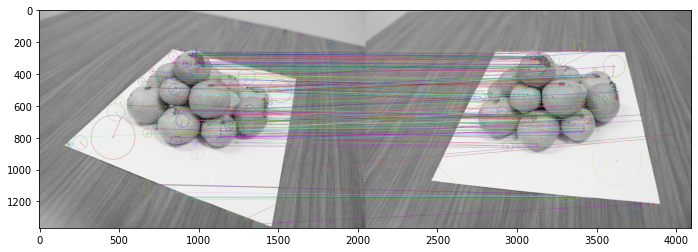

In [31]:
plt.figure(figsize=(12,4))
plt.imshow(matched_image)
plt.show()

---

## Estimate Essential Matrix

`Match points` 중 결과가 좋은 `points`만 추출하여 이것으로부터 `Calibrated 5-pt algorithm with RANSAC`을 이용해 `Essential Matrix`를 계산합니다.

먼저, 정확도가 높은 `Match points`를 추출합니다.

In [39]:
ratio = 0.75
good_matches = [m for m, n in matches if m.distance < ratio * n.distance]
img0_pt = np.int32([kp[0][m.queryIdx].pt for m in good_matches])
img1_pt = np.int32([kp[1][m.trainIdx].pt for m in good_matches])

추출된 `Match points`를 `Homogeneous points`로 만들고 `Intrinsic parameter`로 `normalize`합니다. (`hat symbol`은 `normalized coordinate`을 의미합니다.)

$$\hat{\bf{x}} = \bf{K^{-1}x}$$

In [33]:
# Load Intrinsic Parameters
def readCamera(filename):
    with open(filename, 'r') as f:
        line = f.readline()
    line = line.rstrip().replace('[', '').replace(']', '').split(';')
    line = [list(map(float, l.split())) for l in line]
    return np.array(line)

camera_file = 'data/K.txt'
K = readCamera(camera_file)

In [25]:
def homogeneous(v):
    return np.concatenate([v, np.ones((v.shape[0], 1))], axis=1)

def normalizeK(pt, K):
    return (K @ pt.T).T

가장 최적의 `Essential matrix`를 얻기 위해 `calibrated 5-pt algorithm`을 통해 얻어진 `Essential matrix`들에 대해 `RANSAC`을 사용합니다.

전체 `Match points` 중 임의로 5개의 `points`를 고른 뒤, 이로부터 제공받은 `calibrated_fivepoint` 함수를 사용하여 `Essential matrix`들을 얻습니다. (`calibrated_fivepoint`를 그대로 사용하기 위하여 `octave`와 `oct2py`를 사용했으며, `calibrated_fivepoint_helper`는 `octave`를 이용하여 `mex`로 변환했습니다.)

얻어진 `Essential matrix`를 `Fundamental matrix`로 변환하고,

$$\bf{F} = \bf{K^{-T}EK^{-1}}$$

이를 이용해 모든 `Match points`에 대한 `Sampson distance`를 계산합니다.

$$d_s(\bf{x}_{1}, \bf{x}_{2})=\frac{\bf{(x_{2}^{T}Fx_{1})^2}}{\bf{(Fx_{1}[0])^2+(Fx_{1}[1])^2})+(Fx_{2}[0])^2+(Fx_{2}[1])^2}$$

In [35]:
def EtoF(E, K):
    K_inv = np.linalg.inv(K)
    return K_inv.T@E@K_inv

def distSampson(x1, f, x2):
    x1 = x1[:, np.newaxis]
    x2 = x2[:, np.newaxis]
    f_x1 = f @ x1
    x2t_f_x1 = x2.T @ f_x1
    ft_x2 = f.T @ x2

    return x2t_f_x1**2 / (f_x1[0]**2 + f_x1[1]**2 + ft_x2[0]**2 + ft_x2[1]**2)

계산된 `Distance`를 기반으로 `threshold`와 비교하여 `inlier`와 `outlier`를 구분하고 `inlier`의 수와 `distance of inlier`의 합을 이용하여 `error`를 계산합니다. ($\theta$는 `threshold`)

$$ Error = \frac{\sum_{\bf{x\in X_{in}}}{d_{s}(\bf{x}_{1}, \bf{x}_{2})}+\theta(\text{len}(\bf{X})-\text{len}(\bf{X_{in})})}
{\text{len}(\bf{X})}$$

`inlier`의 수와 `error`를 이용해 선택한 `Essential matrix`가 `best`인지 확인하고 갱신합니다. `best`이라면, `inlier ratio`, `number of samples`, `desired confidence`를 이용해 최대 반복 횟수를 갱신하고 최대 반복 횟수에 도달할 때까지 알고리즘을 반복합니다.

$$n_{trials} = \frac{\log(1-\text{desiredConfidence})}
{\log(1-\text{inlierRatio}^\text{nSamples})}$$ 

In [36]:
def nTrials(inlierRatio, nSamples, desiredConfidence):
    return np.log(1-desiredConfidence) / np.log(1-(inlierRatio)**nSamples)

In [37]:
def ransac(pt1, pt2, K=None, threshold=1.0, desiredConfidence=0.9999):
    # make points homogeneous
    pt1 = homogeneous(pt1)
    pt2 = homogeneous(pt2)
    # normalize points
    if K.any():
        pt1_n = normalizeK(pt1, K)
        pt2_n = normalizeK(pt2, K)

    # best values
    bestInlierCount = 0
    bestInliers = []
    bestErr = np.inf
    bestE = []

    nSamples = 5

    # initial iteration count
    m, t = 10000, 1
    while t < m:
        # choose 5 random points
        random_index = np.random.choice(len(pt1), nSamples)
        # normalize feature coordinates
        q1 = pt1_n[random_index].T
        q2 = pt2_n[random_index].T
        
        # calculate essential matrix for randomly chosen 5-pt
        Evec = octave.calibrated_fivepoint(q1, q2)
        E = np.transpose(Evec.reshape(3, 3, -1), (2,0,1)) if len(Evec) else np.array([])
        for e in E:
            # calculate fundamental matrix for E
            F = EtoF(e, K)
            # calculate sampson distances for all match points
            d = np.array([distSampson(pt1[j], F, pt2[j]) for j in range(len(pt1))]).squeeze()

            # find inlier indxes
            inlier_indexes = np.nonzero(d < threshold)[0]
            inlierCount = len(inlier_indexes)
            total_count = len(pt1)
            Err = (sum(d[inlier_indexes]) + (total_count - inlierCount)*threshold) / total_count

            # update the best values
            if ( inlierCount > bestInlierCount or (inlierCount == bestInlierCount and Err < bestErr ) ):
                bestInlierCount = inlierCount
                bestErr = Err
                bestInliers = inlier_indexes
                bestE = e

                # update max iteration count
                inlierRatio = inlierCount / total_count
                m = nTrials(inlierRatio, nSamples, desiredConfidence)
        t = t+1

    # final inlier points
    in1 = pt1[bestInliers]
    in2 = pt2[bestInliers]
    # final outlier points
    out1 = pt1[np.setdiff1d(range(len(pt1)), bestInliers)]
    out2 = pt2[np.setdiff1d(range(len(pt2)), bestInliers)]
    # final Essential Matrix
    E = bestE

    return E, in1, in2, out1, out2

In [40]:
E, in1, in2, out1, out2 = ransac(img0_pt, img1_pt, K=K, threshold=0.8)
print(f'Essential Matrix: \n{E}')

/tmp/ipykernel_21029/240530043.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.log(1-desiredConfidence) / np.log(1-(inlierRatio)**nSamples)


Essential Matrix: 
[[ 2.13095635e-07 -8.38373183e-07 -1.09197072e-02]
 [ 4.16824318e-07  5.81462942e-07 -7.07024280e-01]
 [-1.67540904e-01  6.86969776e-01  4.52732661e-07]]


---

## Essential Matrix Decomposition

얻어진 `Essential Matrix`를 `SVD`를 통해 분해합니다.

$$ \bf{U, S, V^{T}} = \text{SVD(E)} $$

이로부터 `rotation`과 `transition`은 다음과 같이 구합니다. 여기서 `transition`은 $\bf{U}$의 `third column`을 의미합니다.

$$ R_1 = \bf{UWV^T}, R2 = \bf{UW^TV^T}, T = U(:, 3)$$

`rotation`의 경우 `determinant`를 계산하여 `음수`가 나오는 경우, `reflected rotation`을 의미하므로, `negative`를 가합니다.

In [42]:
def decomposeEssentialMat(E):
    u, _, vt = np.linalg.svd(E)
    w = np.array([
        [0, -1, 0],
        [1, 0, 0],
        [0, 0, 1]
    ])
    r1 = u @ w.T @ vt
    r2 = u @ w @ vt
    r1 = r1 if np.linalg.det(r1) > 0 else -r1
    r2 = r2 if np.linalg.det(r2) > 0 else -r2
    t = u[:, 2]

    return r1, r2, t

In [43]:
r1, r2, t = decomposeEssentialMat(E)

## Triangulation

먼저 `reference`에 `intrinsic parameter`를 가해 `camera matrix`를 구합니다.

$$ P_1 = K [I|O] $$

다음으로 다른 하나의 점에 대해서는 네 가지 가능성 $(R_1, T), (R_2, T), (R_1, -T), (R_2, -T)$ 이 존재합니다. 이 중 가장 많은 `points`에 대해 양의 깊이를 갖는 조합을 선택합니다.

$$ P_2 = K [R|T] $$

In [44]:
def RT(R, T):
    return np.concatenate([R, T[:, np.newaxis]], axis=1)

In [45]:
# Get camera matrix of reference
P1 = K @ RT(np.identity(3), np.zeros((3,)))

# Get probable camera matrix of train
e_set = [(r1, t), (r2, t), (r1, -t), (r2, -t)]
Ps = [K@RT(rot, trans) for rot, trans in e_set]

각 `camera matrix`를 이용하여 `triangulation`을 통해 각 `match points`에 대한 `3D points`를 계산합니다.

$$
A = \begin{bmatrix}
xP_3^T - P_1 \\
yP_3^T - P_2 \\
x'P_E^{'T} - P^{'}_1 \\
y'P_E^{'T} - P^{'}_2 \\
\end{bmatrix}\\
$$

위의 `Matrix`에 대해 아래와 같은 `homogeneous linear system`에 대한 답을 구해야합니다.

$$\bf{AX} = 0$$

이를 위해 $A^{T}A$에 대한 `eigen vector`와 `eigen values`를 얻고, 가장 작은 `eigen value`를 갖는 `eigen vector`를 정답으로 취합니다.

In [47]:
def triangulation(P1, P2, in1, in2):
    X = []
    for i1, i2 in zip(in1, in2):
        A = np.array([
            i1[0] * P1[2] - P1[0],
            i1[1] * P1[2] - P1[1],
            i2[0] * P2[2] - P2[0],
            i2[1] * P2[2] - P2[1]
        ])
        vals, vecs = np.linalg.eig(A.T @ A)
        X.append(vecs[:, np.argmin(vals)])
    return np.array(X)

`reference camera matrix`와 모든 `camera matrix` 간의 `3D points`를 계산한 후, 각 점을 `homogeneous points`로 변환합니다.

In [48]:
rs = [triangulation(P1, P2, in1, in2) for P2 in Ps]
rs = [r/r[:,3,np.newaxis] for r in rs]

가장 많은 `positive depth points`를 가진 `rotation`과 `transition`을 구하고, 그에 대한 `3D points`를 얻습니다.

In [49]:
best_ind = np.argmax(np.sum([r[:,2]>=0 for r in rs], axis=1))
r = rs[best_ind]

---

## Visualization by MeshLab

주어진 `SavePLY` 함수를 이용하여 얻어진 `3D points`를 저장합니다.

In [52]:
# Add color to 3D points
img = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in img]
color = img[0][in1[:,1].astype(np.int64),in1[:,0].astype(np.int64)]
r = np.concatenate([r, color], axis=1)

# Save PLY file
octave.SavePLY('calculated_structure.ply', r.T)